In [1]:
import numpy as np
import pandas as pd
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets import make_blobs, make_circles
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import requests 
from collections import Counter
import random
import decimal
import math
import random
from statsmodels.tsa.ar_model import AutoReg, ar_select_order

In [2]:
##------------------------------Pegando os Dados-----------------------------------

url = "https://apitempo.inmet.gov.br/estacao/diaria/2015-01-01/2019-12-31/A307"
headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.102 Safari/537.36'}
resp = requests.get(url, headers=headers)
df = None
df_temp = None
if resp.status_code != 200:
    print (resp.raise_for_status())
else:
    df = pd.DataFrame(resp.json())
    df.dropna(inplace=True)
    #df = df[df["TEM_MAX"].astype('float') ]
    df_temp = df[df['TEMP_MAX'].notnull()]
    df_temp = df[df['UMID_MED'].notnull()]
    
    df_temp = df[['TEMP_MAX', 'UMID_MED', 'DT_MEDICAO']]
    df_temp["id"] = df.index + 1 

    df_umid = df[df['UMID_MED'].notnull()]
    df_umid = df[['UMID_MED']]
    df_umid["id"] = df.index + 1
    
    print (df_temp)

     TEMP_MAX UMID_MED  DT_MEDICAO    id
0        32.2     52.7  2015-01-01     1
1        33.7     51.6  2015-01-02     2
2        33.6     47.8  2015-01-03     3
3        32.7       46  2015-01-04     4
4        34.7     46.4  2015-01-05     5
...       ...      ...         ...   ...
1821     35.2     42.7  2019-12-27  1822
1822     31.9     47.6  2019-12-28  1823
1823     34.9     46.3  2019-12-29  1824
1824     33.7     48.7  2019-12-30  1825
1825     29.6     72.3  2019-12-31  1826

[1708 rows x 4 columns]


<ipython-input-2-33ee7c6ef185>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp["id"] = df.index + 1
<ipython-input-2-33ee7c6ef185>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_umid["id"] = df.index + 1


In [3]:

df_training_temp = None
df_training_temp_anomalie_edit = None
desvioPadraoTempTraining = 0
desvioPadraoUmidTraining = 0

desvioPadraoTempTest = 0
desvioPadraoUmidTest = 0

desvioPadrao = 0

def valorFinalTemperatura(df_training_temp_anomalie_edit, treino, equacaoExponencial):
    valorFinalTemp = equacaoExponencial * extrairErro(df_training_temp_anomalie_edit, 'TEMP_MAX')
    return valorFinalTemp

def valorFinalUmidade(df_training_temp_anomalie_edit, treino, equacaoExponencial):
    valorFinalUmid = equacaoExponencial * extrairErro(df_training_temp_anomalie_edit, 'UMID_MED')
    return valorFinalUmid

def qtdRowsTemp():
    count_row_temp = df_temp.shape[0]
    return count_row_temp

def extrairErro(dataframe, coluna):
    train_size = int(dataframe.shape[0] * 1)
    train_Real, train_Pred = dataframe.to_numpy()[:,0], dataframe.to_numpy()[:,1]
    train_resid = [train_Real[i]-train_Pred[i] for i in range(len(dataframe))]
    desvioErro = np.std(train_resid)
    return desvioErro

def TransformarEmEstacionaria(df_training_temp):
    converterColunasToFloat(df_training_temp, "TEMP_MAX")
    converterColunasToFloat(df_training_temp, "UMID_MED")

    df_training_temp['UMID_MED'] = df_training_temp['UMID_MED'].diff()
    df_training_temp['TEMP_MAX'] = df_training_temp['TEMP_MAX'].diff()
    df_training_temp.dropna()
    return df_training_temp

def equacaoExponencial():
    numberX = decimal.Decimal(random.randrange(-50, 50))/100
    eq = math.exp((3 * abs(numberX))) + 3
    return float(eq)

def converterColunasToFloat(dataframe, coluna):
    dataframe[coluna] = dataframe[coluna].astype(float)
    dataframe[coluna].apply(lambda x: float(x))
    return dataframe


def autoReg(dataframe_anomalies_edit):
    ar_model = AutoReg(np.array(dataframe_anomalies_edit), trend='n', lags=1).fit()
    pred = ar_model.predict(start=0,end= dataframe_anomalies_edit.shape[0], dynamic=False)
    return pred

In [4]:
#------------------------------Tratando os Dados-----------------------------------

dfAnomaliasFinal =  pd.DataFrame()

def dataTraining(percentOutliers, dbscan):
    
    qtd_training_temp = int(qtdRowsTemp()/3) * 2

    if dbscan:
        qtd_training_temp = qtdRowsTemp()

    df_training_temp = df_temp.sample(qtd_training_temp)

    df_training_temp = TransformarEmEstacionaria(df_training_temp) #Série Estacionária

    count_training_temp = int((df_training_temp.shape[0] * percentOutliers) / 100)    
    df_training_temp_anomalie_edit = df_training_temp.sample(n=count_training_temp)
    
    df_test_temp = pd.concat([df_temp, df_training_temp]).drop_duplicates(keep=False)

    df_training_temp = pd.concat([df_training_temp, df_training_temp_anomalie_edit]).drop_duplicates(keep=False)
    df_training_temp_anomalie_edit.dropna(inplace=True)

    df_training_temp_anomalie_edit = converterColunasToFloat(df_training_temp_anomalie_edit, "TEMP_MAX")
    df_training_temp_anomalie_edit = converterColunasToFloat(df_training_temp_anomalie_edit, "UMID_MED")

    equacaoExpo = equacaoExponencial()
    
    temperaturas = autoReg(df_training_temp_anomalie_edit['TEMP_MAX']) #AutoRegressão
    umidades = autoReg(df_training_temp_anomalie_edit['UMID_MED']) #AutoRegressão
    
    df_ids = np.array(df_training_temp_anomalie_edit['id'])
    
    df_temp_real_pred = pd.DataFrame()
    colTemp = ['temp_real','temp_pred']
    df_temp_real_pred = pd.DataFrame(columns=colTemp)
    df_temp_real_pred['temp_real'] = df_training_temp_anomalie_edit['TEMP_MAX']
    df_temp_real_pred['temp_pred'] = temperaturas.tolist()

    df_umid_real_pred = pd.DataFrame()
    col_umid = ['umid_real','umid_pred']
    df_umid_real_pred = pd.DataFrame(columns=col_umid)
    df_umid_real_pred['umid_real'] = df_training_temp_anomalie_edit['UMID_MED']
    df_umid_real_pred['umid_pred'] = umidades.tolist()
    
    valorFinalTemp = valorFinalTemperatura(df_temp_real_pred, True, equacaoExpo)
    valorFinalUmid = valorFinalUmidade(df_umid_real_pred, True, equacaoExpo)
    
    df_training_temp_anomalie_edit = converterColunasToFloat(df_training_temp_anomalie_edit, "UMID_MED")
    df_training_temp_anomalie_edit = converterColunasToFloat(df_training_temp_anomalie_edit, "TEMP_MAX")

    dfAnomalias = pd.DataFrame()
    col = ['TEMP_MAX','UMID_MED', 'DT_MEDICAO', 'id']

    dfAnomalias = pd.DataFrame(columns=col)

    df_training_temp_anomalie_edit.sort_index(inplace=True)

    for index, row in df_training_temp_anomalie_edit.iterrows():
        temp = row['TEMP_MAX'] + (np.sign(row['TEMP_MAX']) * valorFinalTemp)
        umid = row['UMID_MED'] + (np.sign(row['UMID_MED']) * valorFinalUmid)
        x = np.array([[temp, umid, row['DT_MEDICAO'], row['id']]])
        df1=pd.DataFrame(x, columns=['TEMP_MAX', 'UMID_MED', 'DT_MEDICAO', 'id'])
        
        df1.set_index('id',inplace=True)

        dfAnomalias = pd.concat([df1, dfAnomalias])
   
    dfAnomalias = dfAnomalias.drop(columns='id')
        
    dfAnomalias.sort_index(inplace=True)    

    dfFinal = dfAnomalias
    

    for index, row in df_training_temp.iterrows():
        x = np.array([[row['TEMP_MAX'], row['UMID_MED'], row['DT_MEDICAO'], row['id']]])
        df1=pd.DataFrame(x, columns=['TEMP_MAX', 'UMID_MED', 'DT_MEDICAO', 'id'])
        
        df1.set_index('id',inplace=True)
        
        dfFinal = pd.concat([df1, dfFinal])

    dfFinal.sort_index(inplace=True)    
    df_training_temp = dfFinal
    df_training_temp.dropna(inplace=True)

    dfAnomalias.sort_index(inplace=True)
    df_training_temp.sort_index(inplace=True)
    
    #Treino
    df_training_temp = converterColunasToFloat(df_training_temp, "TEMP_MAX")
    df_training_temp = converterColunasToFloat(df_training_temp, "UMID_MED")
    
    df_training_temp.dropna(inplace=True)
    df_training_temp.sort_index(inplace=True)
    
    #Teste
    count_test_temp = int((df_test_temp.shape[0] * percentOutliers) / 100)
    df_test_temp_anomalie_edit = df_test_temp.sample(n=count_test_temp, random_state=1)
    df_test_temp = pd.concat([df_test_temp, df_test_temp_anomalie_edit]).drop_duplicates(keep=False)
    df_test_temp_anomalie_edit.dropna(inplace=True)
    
    df_test_temp = pd.concat([df_test_temp, df_test_temp_anomalie_edit])
    
    df_test_temp["TEMP_MAX"] = df_test_temp["TEMP_MAX"].astype(float)
    df_test_temp["UMID_MED"] = df_test_temp["UMID_MED"].astype(float)
    
    df_test_temp = converterColunasToFloat(df_test_temp, "TEMP_MAX")
    df_test_temp = converterColunasToFloat(df_test_temp, "UMID_MED")
    
    df_test_temp.sort_index(inplace=True)

    df_test_temp.dropna(inplace=True)
    df_test_temp = df_test_temp.drop(columns='id')
    desvioPadrao = (desvioPadraoTempTraining + desvioPadraoUmidTraining) / 2
    return df_training_temp, df_test_temp, dfAnomalias

In [5]:
taxaContaminacao = 2
dfs = dataTraining(taxaContaminacao, True)
df_training_temp = dfs[0]
df_test_temp = dfs[1]
dfAnomalias = dfs[2]

dfAnomalias = dfAnomalias.sort_values(by="DT_MEDICAO")

print (dfAnomalias.shape)
print ("Anomalias:")
print (dfAnomalias)

df_training_temp = converterColunasToFloat(df_training_temp, "TEMP_MAX")
df_training_temp['TEMP_MAX'] = df_training_temp['TEMP_MAX'].abs()

df_training_temp = df_training_temp[df_training_temp.index.notnull()]

df_training_temp = df_training_temp.sort_values(by="DT_MEDICAO")
df_training_temp

/home/anderson/Documentos/Python/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(
/home/anderson/Documentos/Python/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


(33, 3)
Anomalias:
                 TEMP_MAX             UMID_MED  DT_MEDICAO
3     -19.271933610123952    77.88788380931211  2015-01-03
195    16.071933610123956    77.18788380931213  2015-07-14
374   -16.771933610123956    97.38788380931213  2016-01-09
405   -20.171933610123954    94.08788380931213  2016-02-09
430     17.57193361012395    77.38788380931211  2016-03-05
445   -16.971933610123955   -77.68788380931213  2016-03-20
654   -17.171933610123958    80.48788380931212  2016-10-15
669    19.471933610123955   -90.28788380931212  2016-10-30
687     18.17193361012395    94.88788380931211  2016-11-17
709    -18.27193361012396    92.98788380931214  2016-12-09
803    17.271933610123952   -86.28788380931212  2017-03-13
846    16.371933610123953   -78.48788380931214  2017-04-25
899    -18.27193361012396    86.38788380931213  2017-06-17
921   -22.971933610123955    83.88788380931211  2017-07-09
946   -19.071933610123956    81.08788380931213  2017-08-03
950   -16.371933610123953   -97.38788

,TEMP_MAX,UMID_MED,DT_MEDICAO
1,5.600000,14.700000,2015-01-01
2,0.200000,2.800000,2015-01-02
3,19.271934,77.887884,2015-01-03
4,2.700000,3.800000,2015-01-04
5,1.200000,-2.700000,2015-01-05
...,...,...,...
1822,0.300000,-5.800000,2019-12-27
1823,3.400000,9.600000,2019-12-28
1824,3.300000,16.700000,2019-12-29
1825,0.500000,7.300000,2019-12-30


In [6]:
from gtda.plotting import plot_diagram, plot_point_cloud
import gtda.time_series as time_series
import gtda.diagrams as diag
import gtda.homology as hl
import gtda.graphs as gr
from gtda.plotting import plot_diagram, plot_point_cloud
from plotting.plotting import plot_crash_detections, plot_crash_comparisons
from gtda.pipeline import Pipeline

data = np.array(df_training_temp)

df_training_temp.head()
df_training_temp.tail()
df_training_temp.shape

df_training_temp.dropna(inplace=True)
df_training_temp = converterColunasToFloat(df_training_temp, "TEMP_MAX")
df_training_temp['DT_MEDICAO'] = df_training_temp['DT_MEDICAO'].astype('datetime64')


temps_resampled_df = pd.DataFrame(df_training_temp, columns = ['DT_MEDICAO', 'TEMP_MAX'])

temps_resampled_df['DT_MEDICAO'] = temps_resampled_df['DT_MEDICAO'].astype('datetime64')

temps_resampled_df.set_index('DT_MEDICAO',inplace=True)

temps_values = temps_resampled_df["TEMP_MAX"].tolist()

df_training_temp

,TEMP_MAX,UMID_MED,DT_MEDICAO
1,5.600000,14.700000,2015-01-01
2,0.200000,2.800000,2015-01-02
3,19.271934,77.887884,2015-01-03
4,2.700000,3.800000,2015-01-04
5,1.200000,-2.700000,2015-01-05
...,...,...,...
1822,0.300000,-5.800000,2019-12-27
1823,3.400000,9.600000,2019-12-28
1824,3.300000,16.700000,2019-12-29
1825,0.500000,7.300000,2019-12-30


In [7]:
embedding_dimension = 3
embedding_time_delay = 2
embedder = time_series.SingleTakensEmbedding(
    parameters_type="fixed",
    dimension=embedding_dimension,
    time_delay=embedding_time_delay,
    n_jobs=-1,
)

In [8]:
temps_embedded = embedder.fit_transform(temps_values) #listas com 3 elementos pulando a cada 2 elementos do DF

embedder_time_delay = embedder.time_delay_
embedder_dimension = embedder.dimension_


In [9]:
#Em seguida, aplicamos uma janela deslizante para obter as nuvens de pontos por janela. 
#Escolhemos o tamanho da janela de forma que cada intervalo abranja um período de 36 dias:

window_size = 31  #As janelas terão 31 elementos
window_stride = 4 #A cada nova janela 4 elementos(listas) da lista anterior são saltados

In [10]:
sliding_window = time_series.SlidingWindow(size=window_size, stride=window_stride)
temps_embedded_windows = sliding_window.fit_transform(temps_embedded)

In [11]:
#Visualizando uma das janelas
window_num = 1
point_cloud = temps_embedded_windows[window_num][:, :3]


In [12]:
#Aqui, criamos uma linha de base simples que rastreia a primeira 
#derivada de nossa série temporal em uma janela deslizante. 
#Usando a classe SlidingWindow de giotto-learn, podemos obter 
#rapidamente arrays que são adequados para as APIs scikit-learn:


window_size_temps = window_size + (embedder_dimension * embedder_time_delay) - 2 #As janelas terão 35 elementos
sliding_window_temps = time_series.SlidingWindow(size=window_size_temps, stride=window_stride)
temps_values = np.array(temps_values)
window_indices = sliding_window_temps.slice_windows(temps_values)
temps_windows = sliding_window_temps.fit_transform(temps_values)

abs_derivative_of_means = np.abs(np.mean(np.diff(temps_windows, axis=0), axis=1))


In [13]:
# define o índice de tempo para combinar com arrays numpy
indices = [win[1] - 1 for win in window_indices[1:]]
time_index_derivs = temps_resampled_df.iloc[indices].index

In [14]:
resampled_temps_derivs = temps_resampled_df.loc[time_index_derivs]

In [15]:
homology_dimensions = (0, 1)
VR = hl.VietorisRipsPersistence(homology_dimensions=homology_dimensions, n_jobs=-1)
diagrams = VR.fit_transform(temps_embedded_windows)


In [16]:
from joblib import Parallel, delayed, effective_n_jobs

from sklearn.utils import gen_even_slices
from sklearn.utils.validation import check_is_fitted

from gtda.diagrams import PairwiseDistance
from gtda.diagrams._metrics import _parallel_pairwise, landscapes, betti_curves
from gtda.diagrams._utils import _subdiagrams
from gtda.utils.validation import check_diagrams


class HomologicalDerivative(PairwiseDistance):
    def __init__(self, **kw_args):
        super().__init__(**kw_args)

    def _derivatives_generic(self, X, s):

        return np.array(
            [
                _parallel_pairwise(
                    np.expand_dims(X[t + 1], axis=0),
                    np.expand_dims(X[t], axis=0),
                    self.metric,
                    self.effective_metric_params_,
                    self.homology_dimensions_,
                    self.n_jobs,
                )[0, 0]
                for t in range(s.start, s.stop, 1)
            ]
        )

    def _derivatives(self, subdiagrams, kind, dim, params):
        n_samples, n_points = subdiagrams.shape[:2]
        if kind == "landscape":
            n_layers = min(params["n_layers"], n_points)
            features = landscapes(subdiagrams, params["samplings"][dim], n_layers)
        elif kind == "betti":
            features = betti_curves(subdiagrams, params["samplings"][dim])
        features = (features[1:] - features[:-1]).reshape(n_samples - 1, -1)
        features = np.linalg.norm(features, axis=1, ord=params["p"])

        return (params["step_sizes"][dim] ** (1 / params["p"])) * features

    def fit(self, X, y=None):
        super().fit(X, y)

        return self

    def transform(self, X, y=None):
        check_is_fitted(self, ["effective_metric_params_", "homology_dimensions_"])
        X = check_diagrams(X)

        if self.metric in ["landscape", "betti"]:
            Xt = Parallel(n_jobs=self.n_jobs)(
                delayed(self._derivatives)(
                    _subdiagrams(X[s.start : s.stop + 1], [dim], remove_dim=True),
                    self.metric,
                    dim,
                    self.effective_metric_params_,
                )
                for dim in self.homology_dimensions_
                for s in gen_even_slices(len(X) - 1, effective_n_jobs(self.n_jobs))
            )
            Xt = np.concatenate(Xt)
            Xt = Xt.reshape(len(self.homology_dimensions_), len(X) - 1).T
        else:
            Xt = Parallel(n_jobs=self.n_jobs)(
                delayed(self._derivatives_generic)(X, s)
                for s in gen_even_slices(len(X) - 1, effective_n_jobs(self.n_jobs))
            )
            Xt = np.concatenate(Xt)

        if self.order is not None:
            Xt = np.linalg.norm(Xt, axis=1, ord=self.order)

        return Xt

In [17]:
metric_params = {"p": 2, "n_layers": 10, "n_bins": 1000}

landscape_hom_der = HomologicalDerivative(
    metric="landscape", metric_params=metric_params, order=2, n_jobs=-1
)
landscape_succ_dists = landscape_hom_der.fit_transform(diagrams)


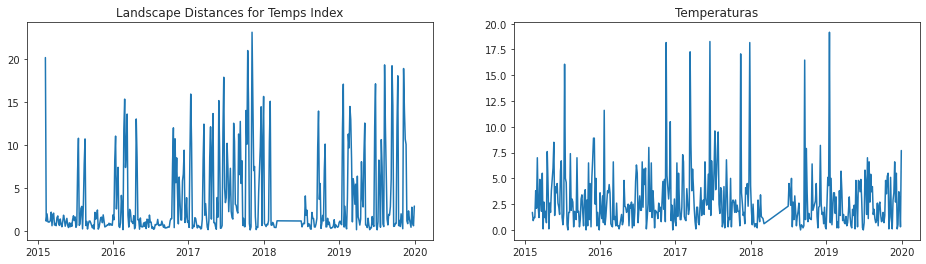

In [18]:
plt.figure(figsize=(16, 4))
plt.subplot(1, 2, 1)
plt.plot(time_index_derivs, landscape_succ_dists, color="#1f77b4")
plt.title("Landscape Distances for Temps Index")

plt.subplot(1, 2, 2)
plt.plot(resampled_temps_derivs, "#1f77b4")
plt.title("Temperaturas")
plt.show()

In [19]:
metric_params = {"p": 2, "n_bins": 1000}


bettiHomDer = HomologicalDerivative(
    metric='betti', metric_params=metric_params, order=2, n_jobs=-1
)
betti_succ_dists = bettiHomDer.fit_transform(diagrams)

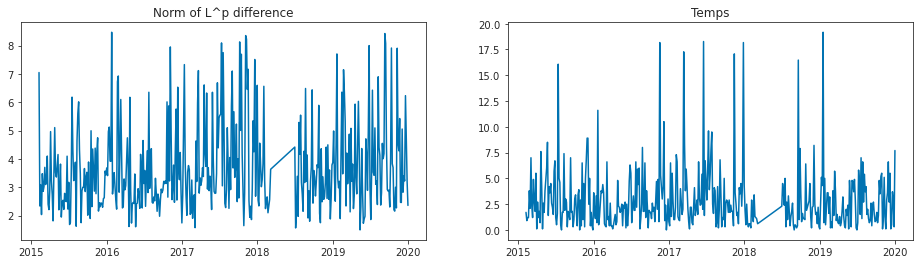

In [20]:
plt.figure(figsize=(16, 4))
plt.subplot(1, 2, 1)
plt.plot(time_index_derivs, betti_succ_dists)
plt.title('Norm of L^p difference')

plt.subplot(1, 2, 2)
plt.plot(resampled_temps_derivs)
plt.title('Temps')
plt.show()

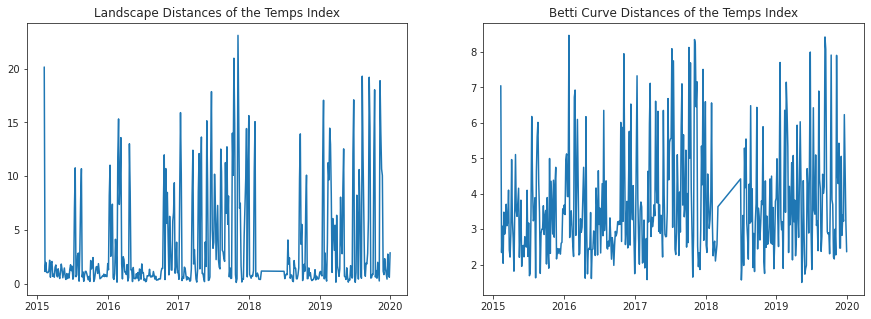

In [21]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(time_index_derivs, landscape_succ_dists, "#1f77b4")
plt.title("Landscape Distances of the Temps Index")

plt.subplot(1, 2, 2)
plt.plot(time_index_derivs, betti_succ_dists, "#1f77b4")
plt.title('Betti Curve Distances of the Temps Index')
plt.show()

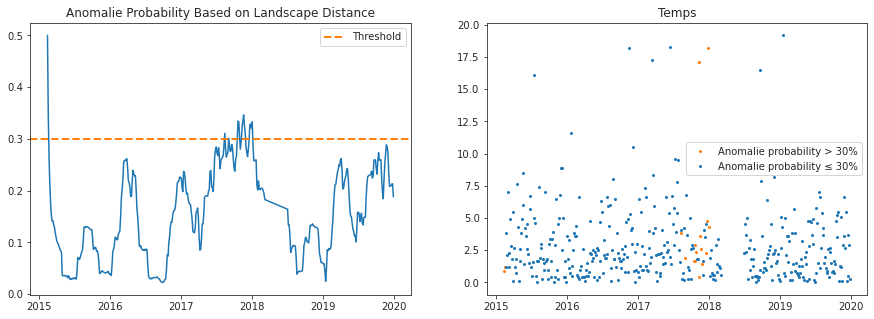

In [22]:
plot_crash_detections(
    start_date="2015-01-01",
    end_date="2019-12-31",
    threshold=0.3,
    distances=landscape_succ_dists,
    time_index_derivs=time_index_derivs,
    price_resampled_derivs=resampled_temps_derivs,
    metric_name='Landscape Distance'
)


In [23]:
start_date="2015-01-01"
end_date="2019-12-31"
rolled_mean_h = pd.Series(landscape_succ_dists).rolling(20, min_periods=1).mean()
rolled_min_h = (pd.Series(landscape_succ_dists).rolling(len(landscape_succ_dists), min_periods=1).min())
rolled_max_h = (pd.Series(landscape_succ_dists).rolling(len(landscape_succ_dists), min_periods=1).max())

threshold_Ceil= 0.4
threshold_Floor= -5
threshold=0.3

probability_of_crash_h = (rolled_mean_h - rolled_min_h) / (rolled_max_h - rolled_min_h)
is_date_in_interval = (time_index_derivs > pd.Timestamp(start_date)) & (time_index_derivs < pd.Timestamp(end_date))
probability_of_crash_h_region = probability_of_crash_h[is_date_in_interval]
resampled_temps_region = resampled_temps_derivs.loc[is_date_in_interval]
resampled_temps_region[probability_of_crash_h_region.values > 0.4]


,TEMP_MAX
DT_MEDICAO,
2015-02-12,0.9


In [24]:
resampled_temps_region[probability_of_crash_h_region.values <= threshold]

,TEMP_MAX
DT_MEDICAO,
2015-02-20,1.2
2015-02-24,3.8
2015-02-28,2.1
2015-03-04,7.0
2015-03-08,2.3
...,...
2019-12-11,0.1
2019-12-15,0.5
2019-12-19,3.7
